# Image segmentation

This tutorial focuses on the task of image segmentation, using a modified <a href="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/" class="external">U-Net</a>.

## What is image segmentation?
So far you have seen image classification, where the task of the network is to assign a label or class to an input image. However, suppose you want to know where an object is located in the image, the shape of that object, which pixel belongs to which object, etc. In this case you will want to segment the image, i.e., each pixel of the image is given a label. Thus, the task of image segmentation is to train a neural network to output a pixel-wise mask of the image. This helps in understanding the image at a much lower level, i.e., the pixel level. Image segmentation has many applications in medical imaging, self-driving cars and satellite imaging to name a few.

The dataset that will be used for this tutorial is the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/), created by Parkhi *et al*. The dataset consists of images, their corresponding labels, and pixel-wise masks. The masks are basically labels for each pixel. Each pixel is given one of three categories :

*   Class 1 : Pixel belonging to the pet.
*   Class 2 : Pixel bordering the pet.
*   Class 3 : None of the above/ Surrounding pixel.

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-5ru81ydv
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-5ru81ydv
  Created wheel for tensorflow-examples: filename=tensorflow_examples-ad5eea57a0171892e313f6ce0d2c48242ef24bdc_-cp37-none-any.whl size=265894 sha256=ebe752ce59d5e2237dacc750922e4c8a35fffb1792d867db69fea6c4f92eefb1
  Stored in directory: /tmp/pip-ephem-wheel-cache-vy0dmqqx/wheels/83/64/b3/4cfa02dc6f9d16bf7257892c6a7ec602cd7e0ff6ec4d7d714d
Successfully built tensorflow-examples


In [ ]:
!pip install tensorflow_addons
import tensorflow_addons as tfa

     |████████████████████████████████| 686kB 6.7MB/s 


In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow_examples.models.pix2pix import pix2pix

#import tensorflow_datasets as tfds

from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import os

## Download the Oxford-IIIT Pets dataset

The dataset is already included in TensorFlow datasets, all that is needed to do is download it. The segmentation masks are included in version 3+.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/mila_segmentation/train/
!unzip train.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/mask/02eeb67c08ba7d58.bmp  
  inflating: train/mask/99cf10190b9ef7a8.bmp  
  inflating: train/mask/49c3301a944fa6d4.bmp  
  inflating: train/mask/3205e6fbeee61c71.bmp  
  inflating: train/mask/287397bbb6d6da5b.bmp  
  inflating: train/mask/ba932d3782302907.bmp  
  inflating: train/mask/069eeb443c3f3a19.bmp  
  inflating: train/mask/2f22d04d4d2ca50e.bmp  
  inflating: train/mask/a41ccd8b5735e75b.bmp  
  inflating: train/mask/db64957a048ba3ff.bmp  
  inflating: train/mask/aa8db9e7ec54aa00.bmp  
  inflating: train/mask/7092526230cbf258.bmp  
  inflating: train/mask/291dc77d569d7b7e.bmp  
  inflating: train/mask/1114ea82a19d6369.bmp  
  inflating: train/mask/9ef31ad71b1967db.bmp  
  inflating: train/mask/341494ef8461e1ed.bmp  
  inflating: train/mask/5ffea3b440151026.bmp  
  inflating: train/mask/85315c4c4e36268a.bmp  
  inflating: train/mask/3e1dc74a7e82fdae.bmp  
  inflating: train/mask/e82d5ff63d8cebc1.bmp  
  inflati

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
#from keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle
import matplotlib.image as mpimg
import pandas as pd
from sklearn.model_selection import train_test_split
from numpy import asarray
import matplotlib.pyplot as plt
import PIL
from tensorflow.python.keras import backend as K
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from keras.layers import Input
from sklearn.metrics import confusion_matrix
import gc
import math
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
from skimage.transform import resize


from subprocess import call
import argparse
import glob
import os
import torch
import re

In [ ]:
img_path = '/content/gdrive/MyDrive/mila_segmentation/train/train/img/'
mask_path = '/content/gdrive/MyDrive/mila_segmentation/train/train/mask/'

img_dir = os.listdir('/content/gdrive/MyDrive/mila_segmentation/train/train/img/')
mask_dir = os.listdir('/content/gdrive/MyDrive/mila_segmentation/train/train/mask/')
#shuffle(all_files)

img_dir = sorted(img_dir)
mask_dir = sorted(mask_dir)

split = int(0.92 * len(img_dir))

#split into training and testing
train_img_filenames = img_dir[0:split]
test_img_filenames  = img_dir[split:]


train_mask_filenames = mask_dir[0:split]
test_mask_filenames  = mask_dir[split:]

#train_img_filenames, train_img_filenames, train_mask_filenames, test_mask_filenames = train_test_split(img_dir, mask_dir, test_size=0.2, random_state=42)

num_train_examples = len(train_mask_filenames)
num_val_examples = len(test_mask_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of validation examples: {}".format(num_val_examples))

print(train_img_filenames)
print(train_mask_filenames)

#train_generator = image_generator(train_files, batch_size = batch_size)
#test_generator  = image_generator(test_files, batch_size = batch_size)

Number of training examples: 20753
Number of validation examples: 1805
['000172d1dd1adce0.jpg', '0002f94fe2d2eb9f.jpg', '0004fdbc5b94c7c2.jpg', '0007e8279612ac07.jpg', '000912f449df9180.jpg', '000a017e2b7063a7.jpg', '000b39037205b35d.jpg', '0010ddb463f2b338.jpg', '00147d2574f2b03a.jpg', '0014e37fd9044ff1.jpg', '0016aebaa93de727.jpg', '001b5a3eae515477.jpg', '002030386a2ce813.jpg', '0021250a98755eaa.jpg', '00221bd372b1d6ec.jpg', '0024096b6bb04ccc.jpg', '00246c2940caa984.jpg', '00251421b2aff498.jpg', '0026b015108cf96b.jpg', '002d3508ff17aff9.jpg', '002e263e97b623c4.jpg', '00351f3a03ca44c2.jpg', '0036cfaac8481eed.jpg', '0036d59a70e627dd.jpg', '0036d85bcfd14c4f.jpg', '0040ab0142e6f0a9.jpg', '0040be7545c242a9.jpg', '004117000d78b39b.jpg', '0049a01d8c371bed.jpg', '0049bf18a9a93014.jpg', '0049f3279a2e8758.jpg', '0051c9de8894bc94.jpg', '00535745650b8d12.jpg', '005651b788a3f70a.jpg', '005996e12c7ca425.jpg', '0059a7a30e21a83c.jpg', '006508c6e93d9fbb.jpg', '00690161e58556bb.jpg', '006977f7a471ba4

# Vizualize

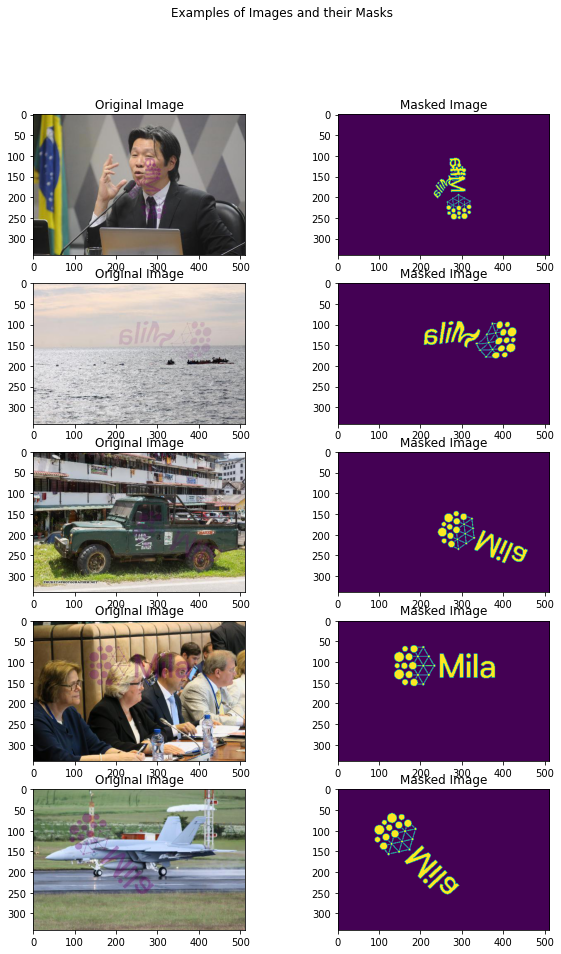

In [ ]:
display_num = 5

r_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2):
  img_num = r_choices[i // 2]
  x_pathname = train_img_filenames[img_num]
  y_pathname = train_mask_filenames[img_num]
  
  plt.subplot(display_num, 2, i + 1)
  filename = img_path + x_pathname
  plt.imshow(mpimg.imread(filename))
  plt.title("Original Image")
  
  example_labels = Image.open(mask_path + y_pathname)
  label_vals = np.unique(example_labels)
  
  plt.subplot(display_num, 2, i + 2)
  plt.imshow(example_labels)
  plt.title("Masked Image")  
  
plt.suptitle("Examples of Images and their Masks")
plt.show()

In [ ]:
def datapoint_maker(x_pathname, y_pathname):
  
   images = Image.open(img_path + x_pathname) 
   masks = Image.open(mask_path + y_pathname)
   images = resize(asarray(images),(128,128))
   masks = resize(asarray(masks),(128,128))

   #check the number of channels because some of the images are RGBA or GRAY
   if len(images.shape) == 2:
          images = np.stack((images,)*3, axis=-1)

   else:
          images = images[:,:,0:3]

   if len(masks.shape) == 2:
          masks = np.stack((masks,)*1, axis=-1)

   else:
          masks = masks[:,:,0]  

   train_images = np.array(images)
   train_masks = np.array(masks)
   #print(images.shape)
   #print(masks.shape)
   return images, masks

In [ ]:
def image_generator(train_img_filenames, batch_size = 2):
  
  while True: 
    
    #extract a random batch 
    batch = np.random.choice(range(len(train_img_filenames)), size = 2)     
    
    #variables for collecting batches of inputs and outputs 
    batch_x = []
    batch_y = []
    
    
    for f in batch:
        #print(f)
        x_pathname = train_img_filenames[f]
        y_pathname = train_mask_filenames[f]
        images, masks = datapoint_maker(x_pathname, y_pathname)
    
        batch_y.append(masks)

        batch_x.append(images)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255.
    batch_y = np.array(batch_y)
    batch_y = np.expand_dims(batch_y,3)

    yield batch_x, batch_y     
    

In [ ]:
test_images = []
test_masks = []

print(len(test_img_filenames))
for f in range(len(test_img_filenames)):
  x_pathname = test_img_filenames[f]
  y_pathname = test_mask_filenames[f]
  
  images = Image.open(img_path + x_pathname) 
  masks = Image.open(mask_path + y_pathname)
  images = asarray(images)
  masks = asarray(masks)

  #check the number of channels because some of the images are RGBA or GRAY
  if len(images.shape) == 2:
          images = np.stack((images,)*3, axis=-1)

  else:
          images = images[:,:,0:3]

  if len(masks.shape) == 2:
          masks = np.stack((masks,)*1, axis=-1)

  else:
          masks = masks[:,:,0]
  
  test_images.append(images)
  test_masks.append(masks)

test_images = np.array(test_images)
test_masks = np.array(test_masks)
print(test_images.shape)
print(test_masks.shape)

1805
(1805, 340, 512, 3)
(1805, 340, 512, 1)


In [ ]:
images, masks = datapoint_maker(train_img_filenames[3], train_mask_filenames[3])
images_test, masks_test = datapoint_maker(train_img_filenames[4], train_mask_filenames[4])
trainer = {'images':images, 'masks':masks}
tester = {'images':images_test, 'masks':masks_test}
print(type(trainer))

<class 'dict'>


The following code performs a simple augmentation of flipping an image. In addition,  image is normalized to [0,1]. Finally, as mentioned above the pixels in the segmentation mask are labeled either {1, 2, 3}. For the sake of convenience, let's subtract 1 from the segmentation mask, resulting in labels that are : {0, 1, 2}.

In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  #input_mask -= 1#tf.cast(input_mask, tf.float32) / tf.math.reduce_max(input_mask)
  return input_image, input_mask

In [ ]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['images'], (128, 128))
  input_mask = tf.image.resize(datapoint['masks'], (128, 128))
  '''
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)
  '''
  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['images'], (128, 128))
  input_mask = tf.image.resize(datapoint['masks'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

The dataset already contains the required splits of test and train and so let's continue to use the same split.

In [ ]:
TRAIN_LENGTH = len(train_mask_filenames)  #info.splits['train'].num_examples
BATCH_SIZE = 2
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
train = load_image_train(trainer)
test = load_image_test(tester)


print(train[0].shape)
print(train[1].shape)

(128, 128, 3)
(128, 128, 1)


In [ ]:
train_dataset = image_generator(train_img_filenames, batch_size = 2)#train.batch(BATCH_SIZE)
test_dataset = image_generator(test_img_filenames, batch_size = 2)#test.batch(BATCH_SIZE)

Let's take a look at an image example and it's correponding mask from the dataset.

(128, 128, 1)


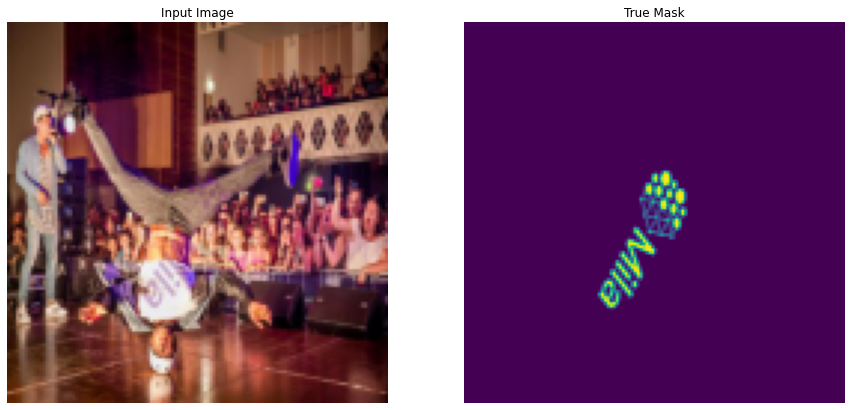

0.9978247


In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

print(train[1].shape)
sample_image, sample_mask = train[0], train[1]
display([sample_image, sample_mask])

print(np.amax(sample_mask))

## Define the model
The model being used here is a modified U-Net. A U-Net consists of an encoder (downsampler) and decoder (upsampler). In-order to learn robust features, and reduce the number of trainable parameters, a pretrained model can be used as the encoder. Thus, the encoder for this task will be a pretrained MobileNetV2 model, whose intermediate outputs will be used, and the decoder will be the upsample block already implemented in TensorFlow Examples in the [Pix2pix tutorial](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py). 

The reason to output three channels is because there are three possible labels for each pixel. Think of this as multi-classification where each pixel is being classified into three classes.

In [ ]:
OUTPUT_CHANNELS = 3

As mentioned, the encoder will be a pretrained MobileNetV2 model which is prepared and ready to use in [tf.keras.applications](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/applications). The encoder consists of specific outputs from intermediate layers in the model. Note that the encoder will not be trained during the training process.

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False


9412608/9406464 [==============================] - 0s 0us/step


The decoder/upsampler is simply a series of upsample blocks implemented in TensorFlow examples.

In [ ]:

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]


In [ ]:

def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,           #2
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)
 

## Train the model
Now, all that is left to do is to compile and train the model. The loss being used here is `losses.SparseCategoricalCrossentropy(from_logits=True)`. The reason to use this loss function is because the network is trying to assign each pixel a label, just like multi-class prediction. In the true segmentation mask, each pixel has either a {0,1,2}. The network here is outputting three channels. Essentially, each channel is trying to learn to predict a class, and `losses.SparseCategoricalCrossentropy(from_logits=True)` is the recommended loss for 
such a scenario. Using the output of the network, the label assigned to the pixel is the channel with the highest value. This is what the create_mask function is doing.

In [ ]:
def boo_net(in_layer,filter,kernel=3,act='relu'):
  a = Conv2D(filter,kernel,activation='relu',padding = 'same')(in_layer)
  amean = GlobalAveragePooling2D()(a)
  amax = GlobalMaxPooling2D()(a)
  acon = concatenate([amean, amax])
  aint = Dense(filter,activation='relu')(acon)
  aat = Dense(filter,activation='sigmoid')(aint)
  a1 = Multiply()([a,aat])

  aout = Add()([a,a1])
  aout = Conv2D(filter,kernel,activation=act,padding = 'same')(aout)
  return aout


In [ ]:
src_image = layers.Input(shape = (128, 128,3))
'''
a = Conv2D(512,3,activation='relu',padding = 'same')(src_image)
a = Conv2D(256,3,activation='relu',padding = 'same')(a)
# a1 = GlobalMaxPool2D()(a)
#a = UpSampling2D()(a)
a = Conv2D(256,3,activation='relu',padding = 'same')(a)
a = Conv2D(256,3,activation='relu',padding = 'same')(a)
# a = Multiply()([Conv2D(256,3,activation='relu',padding = 'same')(a),a1])
# a1 = GlobalMaxPool2D()(a)
'''

m1 = boo_net(src_image, 64)#128,128,64
m1p = MaxPool2D()(m1) #64,64,64
m2 = boo_net(m1p, 64)#64,64,64
m2p = MaxPool2D()(m2) #32,32,64
m3 = boo_net(m2p, 128)#32,32,128
m3p = MaxPool2D()(m3) #16,16,128
m4 = boo_net(m3p, 256)#16,16,256
m4p = MaxPool2D()(m4) #8,8,256

e = boo_net(m4p,128)#8,8,128
u1 = UpSampling2D()(e)#16,16,128
u2 = boo_net(concatenate([u1,m4]),64) #16,16,64
u1 = UpSampling2D()(u2)#32,32,64
u2 = boo_net(concatenate([u1,m3]),64) #32,32,32
u1 = UpSampling2D()(u2)#64,64,64
u2 = boo_net(concatenate([u1,m2]),64) #64,64,16
u1 = UpSampling2D()(u2)#128,128,16
u2 = boo_net(concatenate([u1,m1]),8,act='sigmoid') #128,128,8
a128 = Conv2D(2,3,activation='softmax',padding = 'same')(u2)

model1 = keras.Model((src_image), (a128))
#keras.utils.plot_model(model1, "multi_input_and_output_model.png", show_shapes=True)

In [ ]:
def iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

In [ ]:
'''
import sys
import warnings
warnings.filterwarnings("ignore")

def unet(sz = (128, 128, 3)):
  x = Input(sz)
  inputs = x
  
  #down sampling 
  f = 8
  layers = []
  
  for i in range(0, 6):
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    layers.append(x)
    x = MaxPooling2D() (x)
    f = f*2
  ff2 = 64 
  
  #bottleneck 
  j = len(layers) - 1
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1 
  
  #upsampling 
  for i in range(0, 5):
    ff2 = ff2//2
    f = f // 2 
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 
    
  
  #classification 
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  outputs = Conv2D(1, 1, activation='sigmoid') (x)
  
  #model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [iou])
  
  return model

model1 = unet()
'''

'\nimport sys\nimport warnings\nwarnings.filterwarnings("ignore")\n\ndef unet(sz = (128, 128, 3)):\n  x = Input(sz)\n  inputs = x\n  \n  #down sampling \n  f = 8\n  layers = []\n  \n  for i in range(0, 6):\n    x = Conv2D(f, 3, activation=\'relu\', padding=\'same\') (x)\n    x = Conv2D(f, 3, activation=\'relu\', padding=\'same\') (x)\n    layers.append(x)\n    x = MaxPooling2D() (x)\n    f = f*2\n  ff2 = 64 \n  \n  #bottleneck \n  j = len(layers) - 1\n  x = Conv2D(f, 3, activation=\'relu\', padding=\'same\') (x)\n  x = Conv2D(f, 3, activation=\'relu\', padding=\'same\') (x)\n  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding=\'same\') (x)\n  x = Concatenate(axis=3)([x, layers[j]])\n  j = j -1 \n  \n  #upsampling \n  for i in range(0, 5):\n    ff2 = ff2//2\n    f = f // 2 \n    x = Conv2D(f, 3, activation=\'relu\', padding=\'same\') (x)\n    x = Conv2D(f, 3, activation=\'relu\', padding=\'same\') (x)\n    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding=\'same\') (x)\n    x = Conc

In [ ]:
'''
src_image = layers.Input(shape = (128, 128,3))

m1 = Dense(6,activation='relu')(src_image)#128,128,64
m1 = Dense(20,activation='relu')(m1)#128,128,64
m1 = Dense(1,activation='sigmoid')(m1)#128,128,64

model1 = keras.Model((src_image), (m1))
keras.utils.plot_model(model1, "multi_input_and_output_model.png", show_shapes=True)
'''

'\nsrc_image = layers.Input(shape = (128, 128,3))\n\nm1 = Dense(6,activation=\'relu\')(src_image)#128,128,64\nm1 = Dense(20,activation=\'relu\')(m1)#128,128,64\nm1 = Dense(1,activation=\'sigmoid\')(m1)#128,128,64\n\nmodel1 = keras.Model((src_image), (m1))\nkeras.utils.plot_model(model1, "multi_input_and_output_model.png", show_shapes=True)\n'

In [ ]:
model1.compile(optimizer='rmsprop',#keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[iou])#['accuracy'])

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [ ]:
#model1.fit(np.random.normal(0,1,(10,128,128,3)),np.ones((10,128,128,1)),batch_size=2,epochs=3)

In [ ]:
L = []
L.append(10000)

In [ ]:
def focal_loss_custom(alpha, gamma):
   def binary_focal_loss(y_true, y_pred):
      fl = tfa.losses.SigmoidFocalCrossEntropy(alpha=alpha, gamma=gamma)
      y_true_K = K.ones_like(y_true)
      focal_loss = fl(y_true, y_pred)
      return focal_loss
   return binary_focal_loss


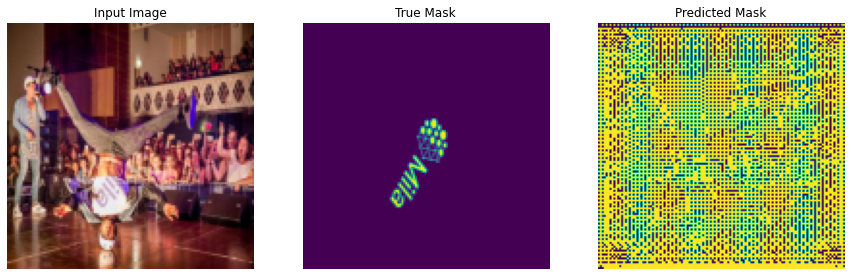


Sample Prediction after epoch 1

 8544/10369 [=======================>......] - ETA: 2:54 - loss: 0.0301 - iou: 1.2193e-05

KeyboardInterrupt: ignored

In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 1
#VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS
VALIDATION_STEPS = 1

for i in range(1000): 
  gc.collect()
  #x,y = train_dataset
  model_history = model.fit(train_dataset, epochs=1, steps_per_epoch=STEPS_PER_EPOCH,
                            validation_steps=VALIDATION_STEPS,
                            validation_data=test_dataset,callbacks=[DisplayCallback()])
  '''
  highest_loss = L[-1]
  L.append(model_history.history['loss'])
  #if model_history.history['loss'][0]<=highest_loss:
    model1.save('model1.h5')
  '''

In [ ]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=focal_loss_custom(alpha=0.2, gamma=2.0),#tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[iou])


Have a quick look at the resulting model architecture:

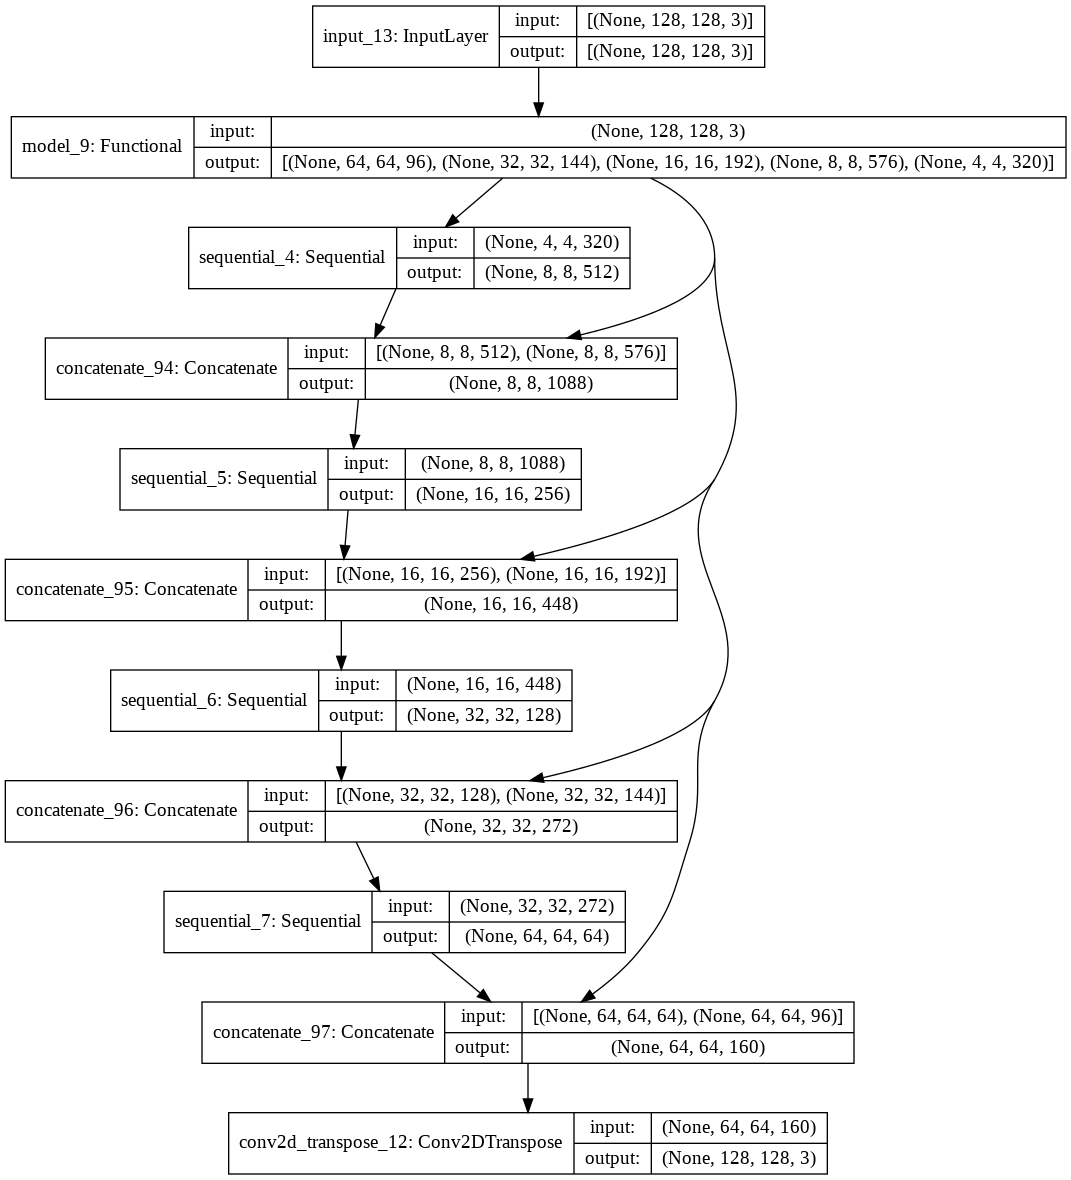

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

Let's try out the model to see what it predicts before training.

In [ ]:
train[0].shape
out = model1.predict(tf.reshape(train[0],(1,128,128,3)))
out1 = out[:,:,:,0]+out[:,:,:,1]
mask = np.reshape(out1,(128,128))


1.0000001

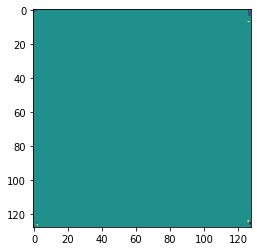

In [ ]:
plt.imshow(mask)
np.amax(mask)

In [ ]:
np.amax(mask)

In [ ]:
show_predictions()

Let's observe how the model improves while it is training. To accomplish this task, a callback function is defined below. 

In [ ]:
'''
if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='Script to benchmark a model on different test sets')
    parser.add_argument('--script_path', type=str, default='./infer.py',
                        help='path of the script to perform inference with the model')
    parser.add_argument('--testset_path', type=str, default='./test/',
                        help='path of the test sets')
    parser.add_argument('--prediction_path', type=str, default='./test/',
                        help='path of the directory where the predictions are saved')
    args = parser.parse_args()

    test_dirs = os.listdir(args.testset_path)
    if not test_dirs:
        test_dirs.append('.')

    score_dict = {}

    script_dir = os.path.dirname(args.script_path)
    script_name = os.path.basename(args.script_path)
    interp_name = './'
    if os.path.splitext(script_name)[1] == '.py':
        interp_name = 'python'
    elif os.path.splitext(script_name)[1] == '.sh':
        interp_name = 'sh'

    for test_name in test_dirs:
        pred_path = os.path.join(args.prediction_path, test_name)
        if not os.path.isdir(pred_path):
            current_wd = os.getcwd()
            os.chdir(script_dir)
            print('Generating the predictions for {} set'.format(test_name))
            call([interp_name, script_name, os.path.join(args.testset_path, test_name, 'img'), pred_path])
            print('Generation done.')
            os.chdir(current_wd)

        test_mask_path = os.path.join(args.testset_path, test_name, 'mask')
        score = compute_metrics(iou, pred_path=pred_path, mask_path=test_mask_path)
        score_dict[test_name] = score

    if len(test_dirs) == 1:
        print('mean IOU on {}: {:.4f}'.format(test_name, score_dict[test_name]))
    else:
        for test_name in test_dirs:
            print('mean IOU on {}: {:.4f}'.format(test_name, score_dict[test_name]))
'''

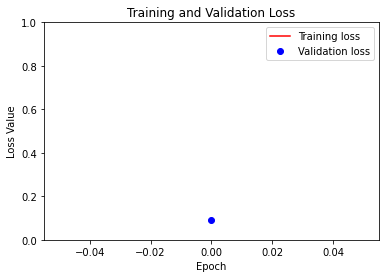

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()